In [1]:
# paper : https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("names.txt", "r", encoding="utf-8").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# building the dataset
X = []
Y = []
block_size = 3 # context length : no. of chars go in at a time to predict next one

for word in words:
    # print(word)
    context = [0] * block_size
    for ch in word + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [9]:
print(X)

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])


In [10]:
# creating embeddings
C = torch.randn((27,2))
# each element in X(i.e 1,2,..27 wil get mapped to C by following operation)
emb = C[X] # have to look deeper into this
emb.shape, C.shape, X.shape

(torch.Size([228146, 3, 2]), torch.Size([27, 2]), torch.Size([228146, 3]))

In [11]:
X[9]

tensor([12,  9, 22])

In [12]:
# for the 5th word
C, emb[9]

(tensor([[ 0.5180,  0.7619],
         [-0.7660, -0.1527],
         [-1.4532,  0.5346],
         [ 0.3929, -0.7426],
         [ 1.1155, -1.2942],
         [ 0.1230,  0.1202],
         [ 2.6891,  0.5051],
         [-1.4468, -0.2872],
         [ 0.2504, -0.3553],
         [-0.0805,  0.4510],
         [ 0.2424, -1.3988],
         [ 0.1719, -1.0280],
         [-0.0066, -0.4935],
         [ 0.1193,  0.1054],
         [ 0.0396,  0.2922],
         [-1.0308, -0.4755],
         [-0.6562, -0.8151],
         [ 0.6963,  1.1134],
         [-0.9225, -0.5202],
         [-0.3870,  0.2156],
         [-0.0205,  1.7891],
         [-0.4322,  0.7770],
         [-0.6737,  0.0496],
         [-0.9988,  0.6579],
         [-0.7668,  0.0292],
         [-0.0418, -0.0619],
         [-1.1571, -0.4720]]),
 tensor([[-0.0066, -0.4935],
         [-0.0805,  0.4510],
         [-0.6737,  0.0496]]))

In [13]:
# our neural net will take on 6 values, why? -> emb[x] or look up
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [14]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (684438x2 and 6x100)

In [21]:
# emb.view((32, 6)) @ W1
# or we can go like: (to not take static values in parameters)
emb.view((-1, 6)) @ W1 + b1

tensor([[ 1.7757,  0.1086,  0.1695,  ...,  5.2078,  0.0576, -3.6471],
        [ 1.7710, -0.2541,  1.2587,  ...,  3.9832,  0.1624, -2.7899],
        [ 1.3498,  0.9215,  0.9537,  ...,  1.9975,  0.0509, -1.2906],
        ...,
        [-2.8550,  4.3762, -3.1155,  ..., -3.7247,  0.4099,  3.0122],
        [-1.2282,  3.0251,  0.0493,  ..., -3.8696,  0.6428,  2.2624],
        [-2.9430,  2.5492,  0.2341,  ..., -4.1112, -0.7236,  2.2522]])

In [22]:
h = emb.view((-1, 6)) @ W1 + b1
h.shape

torch.Size([228146, 100])

In [23]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [24]:
logits = h @ W2 + b2

In [25]:
logits.shape

torch.Size([228146, 27])

In [26]:
# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [27]:
prob[0].sum()

tensor(1.)

In [28]:
prob[torch.arange(X.shape[0]), Y]

tensor([2.2132e-35, 3.0865e-12, 5.4371e-12,  ..., 8.0868e-19, 1.8489e-24,
        3.2681e-19])

In [29]:
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(nan)

In [30]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [31]:
Y, Y.shape

(tensor([ 5, 13, 13,  ..., 26, 24,  0]), torch.Size([228146]))

In [32]:
## better version of above code:

In [33]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [34]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [35]:
for p in parameters:
    p.requires_grad = True

In [36]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [44]:
lri = []
losses = []

for i in range(500000):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # Forward Pass: 
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    ## calculating loss with cross entropy instead of doing it manually,
    # using softmax like above
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward Pass:
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #Update
    for p in parameters:
        p.data += -lrs[i%1000] * p.grad

    # tracking results
    lri.append(lrs[i%1000])
    losses.append(loss.item())
print(loss.item())

2.8774335384368896


In [45]:
# random batches
torch.randint(0,5, (32,))
# we will do the same in training, but we will do it for 0 to X.shape[0]
# so it will predict random element/char_pairs for training

tensor([4, 1, 0, 3, 2, 3, 3, 2, 0, 3, 4, 0, 0, 4, 1, 2, 3, 4, 4, 0, 2, 4, 4, 4,
        0, 2, 4, 1, 1, 0, 2, 1])

In [46]:
# validation/dev loss
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5619, grad_fn=<NllLossBackward0>)

In [47]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.5571, grad_fn=<NllLossBackward0>)

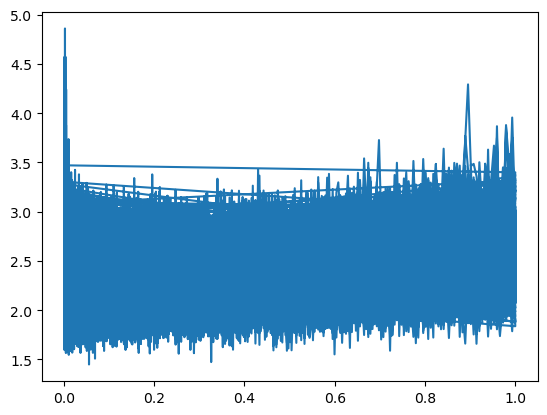

In [48]:
plt.plot(lri, losses)

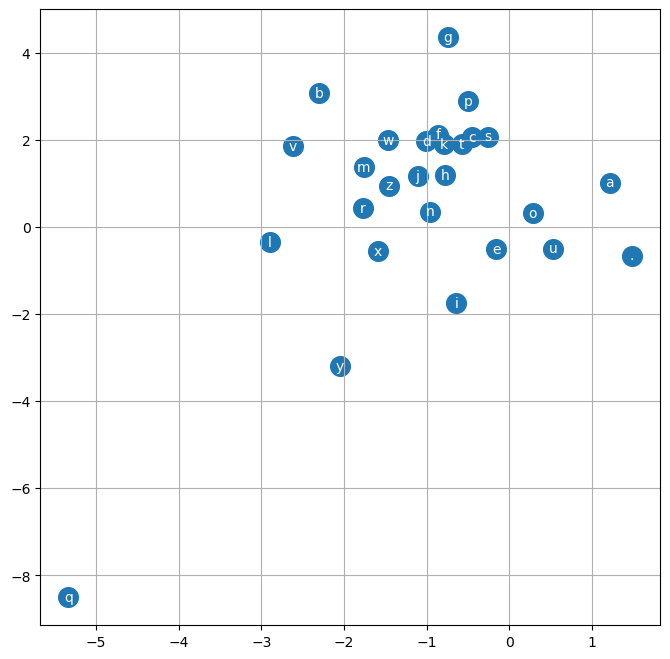

In [49]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [50]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mriahamyah.
seel.
mahayla.
rethantendramiel.
camdielie.
saylaelleighaestanaraelyn.
mamarami.
sadbergahiraestin.
jamiel.
ranteulanustencen.
cyielamela.
maejamannyda.
hamina.
yahsufaurahlee.
ramat.
camivaaostenohdinnentoenah.
zatie.
samueyel.
hararilina.
iri.
